<div class="alert alert-block alert-success">
    <h1 align="center">1-Import the dataset and uzip it</h1>
</div>

In [1]:
from urllib.request import urlretrieve # To download database from websites
import zipfile, os

In [2]:
# If file exists, skip the download
data_file_path = "Data_manager_split_datasets/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

In [3]:
dataFile = zipfile.ZipFile(data_file_path + "movielens_10m.zip") # Define that it is a kinda zip
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = data_file_path + "decompressed/") # Unzip it


In [4]:
URM_file = open(URM_path, 'r') # Open the file

<div class="alert alert-block alert-success">
    <h1 align="center">2-Turn dataset to a dataframe</h1>
</div>

In [5]:
import pandas as pd

In [6]:
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep="::", 
                                header=None, 
                                dtype={0:int, 1:int, 2:float, 3:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction", "Timestamp"]

In [7]:
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
5,1,329,5.0,838983392
6,1,355,5.0,838984474
7,1,356,5.0,838983653
8,1,362,5.0,838984885
9,1,364,5.0,838983707


In [8]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))
print('URM_all_dataframe.shape',URM_all_dataframe.shape)

The number of interactions is 10000054
URM_all_dataframe.shape (10000054, 4)


<div class="alert alert-block alert-success">
    <h1 align="center">3-EDA on data</h1>
</div>

### We can use this data to create a sparse matrix, notice that we have red UserID and ItemID as int
### This is not always possible if the IDs are alphanumeric

## Now we can extract the list of unique user id and item id and display some statistics

In [9]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 10677, Number of users	 69878
Max ID items	 65133, Max Id users	 71567



### See that the max ID of items and users is higher than the number of unique values -> empty profiles
### We should remove empty indices, to do so we create a new mapping

In [10]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique()) # Encode the object as an enumerated type or categorical variable.



In [11]:
mapped_id[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
original_id[:20]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 22, 23])

In [13]:
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [14]:
user_original_ID_to_index

1            0
2            1
3            2
4            3
5            4
         ...  
71563    69873
71564    69874
71565    69875
71566    69876
71567    69877
Length: 69878, dtype: int64

In [15]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [16]:
item_original_ID_to_index

122          0
185          1
231          2
292          3
316          4
         ...  
7537     10672
63481    10673
64652    10674
64427    10675
63662    10676
Length: 10677, dtype: int64

 ### We now replace the IDs in the dataframe and we are ready to use the data

In [17]:
URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)

In [18]:
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [19]:
#let's check the structure of the dataframe again:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

Number of items	 10677, Number of users	 69878
Max ID items	 10676, Max Id users	 69877

Average interactions per user 143.11
Average interactions per item 936.60



In [20]:
print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Sparsity 98.66 %


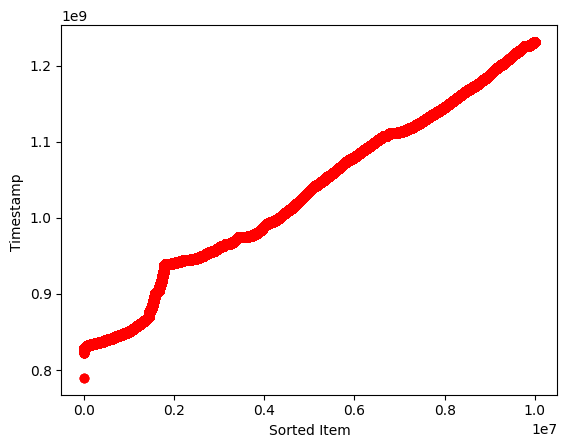

In [21]:
import matplotlib.pyplot as pyplot

# Clone the list to avoid changing the ordering of the original data
timestamp_sorted = URM_all_dataframe["Timestamp"].values.copy()
timestamp_sorted.sort()


pyplot.plot(timestamp_sorted, 'ro')
pyplot.ylabel('Timestamp ')
pyplot.xlabel('Sorted Item')
pyplot.show()

<div class="alert alert-block alert-success">
    <h1 align="center">4-Turn the dataframe to COO, CSR,CSC format matirx</h1>
</div>

#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [22]:
import scipy.sparse as sps

# Step 1 : Turn it to coo matrix with sps.coo_matrix((data, (i, j)), [shape=(M, N)])
URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values,
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))

URM_all

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in COOrdinate format>

In [23]:
# Print the matrix 
URM_all.toarray()

array([[5., 5., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# Step 2: Trun it to CSR matrix with URM_all.tocsr
URM_all.tocsr()
print('list row pointers:',URM_all.tocsr().indptr)
print('Lenght:',len(URM_all.tocsr().indptr))
print('Indices:',URM_all.tocsr().indices)
print('Lenght:',len(URM_all.tocsr().indices))
print('Data:',URM_all.tocsr().data)
print('Lenght:',len(URM_all.tocsr().data))

list row pointers: [       0       22       42 ...  9999952 10000001 10000054]
Lenght: 69879
Indices: [   0    1    2 ... 3386 3448 5330]
Lenght: 10000054
Data: [5. 5. 5. ... 3. 1. 1.]
Lenght: 10000054


In [25]:
# Step 3: Trun it to CSC matrix with URM_all.tocsc
URM_all.tocsc()
print('list column pointers:',URM_all.tocsc().indptr)
print('Lenght:',len(URM_all.tocsc().indptr))
print('Indices:',URM_all.tocsc().indices)
print('Lenght:',len(URM_all.tocsc().indices))
print('Data:',URM_all.tocsc().data)
print('Lenght:',len(URM_all.tocsc().data))

list column pointers: [       0     2412    17387 ... 10000052 10000053 10000054]
Lenght: 10678
Indices: [    0   128   136 ... 65888 67546 69154]
Lenght: 10000054
Data: [5.  3.  2.5 ... 2.  4.  4. ]
Lenght: 10000054


<div class="alert alert-block alert-success">
    <h1 align="center">5-Calculate item-popularity and user-activity</h1>
</div>

### We compute the item popularity as the number of interaction in each column

### We can use the properties of sparse matrices in CSC format

Item_popularity: [ 2412 14975 17851 ...     1     1     1]
Sorted item_popularity: [    1     1     1 ... 33668 34457 34864]
Lenght: 10677


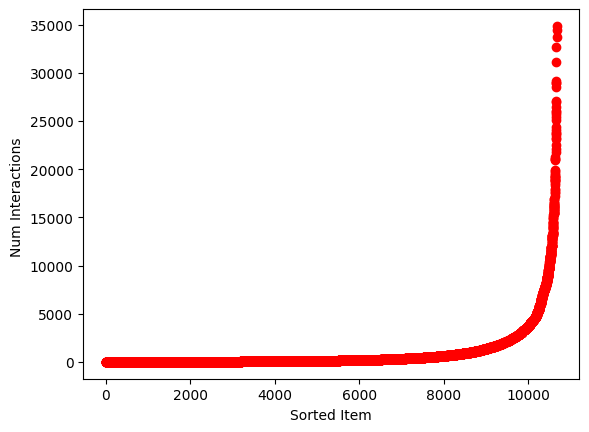

In [26]:
import numpy as np
# ediff1d(The differences between consecutive elements of an array.)
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
print('Item_popularity:',item_popularity)
item_popularity = np.sort(item_popularity)
print('Sorted item_popularity:',item_popularity)
print('Lenght:',len(item_popularity))
# Plot it
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [27]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 936.60
Average per-item interactions for the top 10% popular items 6479.52
Average per-item interactions for the least 10% popular items 5.23
Average per-item interactions for the median 10% popular items 136.45


### We compute the user activity (profile length) as the number of interaction in each row

### We can use the properties of sparse matrices in CSR format

user_activity: [ 22  20  33 ... 145  49  53]
Sorted user_activity: [  20   20   20 ... 5169 7047 7359]
Lenght: 69878


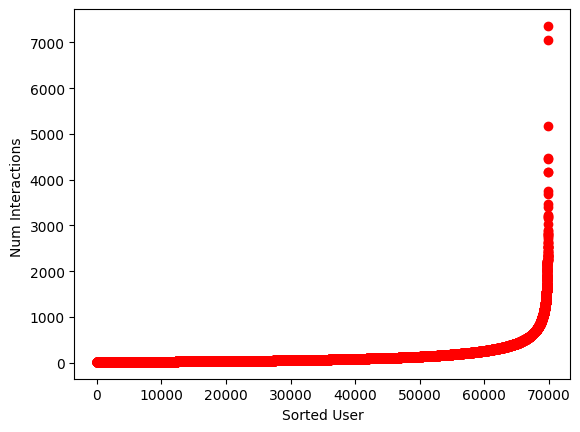

In [28]:
# ediff1d(The differences between consecutive elements of an array.)
user_activity = np.ediff1d(URM_all.tocsr().indptr)
print('user_activity:',user_activity)
user_activity = np.sort(user_activity)
print('Sorted user_activity:',user_activity)
print('Lenght:',len(user_activity))
# Plot it
pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

<div class="alert alert-block alert-success">
    <h1 align="center">6-URM_train and URM_test</h1>
</div>

### In order to evaluate our recommender we have to define:
* A splitting of the data in URM_train and URM_test
* An evaluation metric
* A functon computing the evaluation for each user

### The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:
#### - Train data: we will use this to train our model
#### - Test data: we will use this to evaluate our model

In [29]:
# Step 1: Create train matrix
train_test_split = 0.80
n_interactions = URM_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
print('train_mask',train_mask)

URM_train = sps.csr_matrix((URM_all.data[train_mask],
                            (URM_all.row[train_mask], URM_all.col[train_mask])))

print(f'{len(URM_train.data)}stored elements')
URM_train.toarray()


train_mask [ True  True  True ...  True  True  True]
7998292stored elements


array([[5., 5., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
# Create test matrix
test_mask = np.logical_not(train_mask)
print('test_mask',test_mask)
URM_test = sps.csr_matrix((URM_all.data[test_mask],
                            (URM_all.row[test_mask], URM_all.col[test_mask])))
print(f'{len(URM_test.data)}stored elements')

URM_test.toarray()

test_mask [False False False ... False False False]
2001762stored elements


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<div class="alert alert-block alert-success">
    <h1 align="center">7-Chose random relevant items for a user</h1>
</div>

In [31]:
#Les's see relevant items for an random user like 124
user_id = 124
relevant_items = URM_test[user_id].indices
print(f'relevant_items for user({user_id}) are\n{relevant_items}')
print('-'*60)
# We recommend these items for the user
recommended_items = np.array([241, 1622, 15, 857, 5823])
print(f'recommended_items by us for user({user_id}) are\n{recommended_items}') 

relevant_items for user(124) are
[  27   30   47   71   83   93  146  178  181  225  302  398  399  404
 1008 1079 1318 1429 1469 1603 2771]
------------------------------------------------------------
recommended_items by us for user(124) are
[ 241 1622   15  857 5823]


In [32]:
# Let's check how many of the recommendeD_items are in relavent items
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
print(is_relevant)
print('recommended_items which are in relavent itemsrecommended_items:\t',recommended_items[is_relevant])

[False False False False False]
recommended_items which are in relavent itemsrecommended_items:	 []


<div class="alert alert-block alert-success">
    <h1 align="center">7-Evaluation metrics</h1>
</div>

### Evaluation metric
#### We call items in the test set 'relevant'

### Precision: how many of the recommended items are relevant

In [33]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score



### Recall: how many of the relevant items I was able to recommend

In [34]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

### Average Precision

In [35]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [36]:
precision_score = precision(recommended_items,relevant_items)
print('precision_score',precision_score)
recall_score = recall(recommended_items,relevant_items)
print('recall_score',recall_score)
ap_score = AP(recommended_items,relevant_items)
print('ap_score',ap_score)

precision_score 0.0
recall_score 0.0
ap_score 0.0


<div class="alert alert-block alert-success">
    <h1 align="center">8-Built the first recommender</h1>
</div>

### Now that we have the data, we can build our first recommender. We need two things:
* a 'fit' function to train our model
* a 'recommend' function that uses our model to recommend

### Let's start with a random recommender

#### In a random recommend we don't have anything to learn from the data

In [37]:
class RandomRecommender(object):

    def fit(self, URM_train):
           
        self.n_items = URM_train.shape[1]
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = np.random.choice(self.n_items, at)

        return recommended_items

In [41]:
randomRecommender = RandomRecommender()
randomRecommender.fit(URM_train)

for user_id in range(10):
    print(f'Recommnede_items for user_id({user_id})')
    print(randomRecommender.recommend(user_id, at=5))
    print('-'*40)

Recommnede_items for user_id(0)
[2754 3527  929 3028 1423]
----------------------------------------
Recommnede_items for user_id(1)
[7765 9986 4108 7320 9358]
----------------------------------------
Recommnede_items for user_id(2)
[8247 3530 5494 7184 2771]
----------------------------------------
Recommnede_items for user_id(3)
[ 3146 10185  1704  2182  8272]
----------------------------------------
Recommnede_items for user_id(4)
[1137 3412 6633 4136 6625]
----------------------------------------
Recommnede_items for user_id(5)
[5281 2564 4665 5946  949]
----------------------------------------
Recommnede_items for user_id(6)
[7425 5525  570 9706 9848]
----------------------------------------
Recommnede_items for user_id(7)
[ 7157  6990  7138  7722 10135]
----------------------------------------
Recommnede_items for user_id(8)
[7883 5442 9560 5483 6018]
----------------------------------------
Recommnede_items for user_id(9)
[4748 2606 8889 6917 8485]
-------------------------------

<div class="alert alert-block alert-success">
    <h1 align="center">9-Evaluation on the first recommender</h1>
</div>

### Put all together in an evaluation function and let's test it!

In [42]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]] # Finding relvant_items
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval # Average
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 


In [43]:
evaluate_algorithm(URM_test, randomRecommender)

Recommender results are: Precision = 0.0028, Recall = 0.0005, MAP = 0.0013


## So the code works. The recommendation quality however...

<div class="alert alert-block alert-success">
    <h1 align="center">10-Top popular recommender</h1>
</div>

# Top Popular recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions
#### In this case our model is the item popularity 

In [44]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = self.popular_items[0:at]

        return recommended_items

### Now train and test our model

In [46]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_train)

for user_id in range(10):
    print(f'5 topPopRecommender for user_id({user_id})')
    print(topPopRecommender.recommend(user_id, at=5))
    print('-'*40)

5 topPopRecommender for user_id(0)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(1)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(2)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(3)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(4)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(5)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(6)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(7)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(8)
[1008    7  139   14 1293]
----------------------------------------
5 topPopRecommender for user_id(9)
[1008    7  139   14 1293]
-----------

<div class="alert alert-block alert-success">
    <h1 align="center">11-Evaluation on 5 Top popular recommender</h1>
</div>

In [47]:
evaluate_algorithm(URM_test, topPopRecommender, at=5)

Recommender results are: Precision = 0.0954, Recall = 0.0309, MAP = 0.0524


### That's better, but we can improve

### Hint, remove items already seen by the user. We can either remove them from the recommended item list or we can set them to a score so low that it will cause them to end at the very bottom of all the available items

<div class="alert alert-block alert-success">
    <h1 align="center">12- Five Top popular recommender, while we removed seen items</h1>
</div>

In [48]:
class TopPopRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)

            unseen_items = self.popular_items[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
            

        return recommended_items


In [50]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(URM_train)

for user_id in range(10):
    print(f'five topPopRecommender_removeSeen for user_id({user_id})')
    print(topPopRecommender_removeSeen.recommend(user_id, at=5))
    print('-'*40)

five topPopRecommender_removeSeen for user_id(0)
[1008  139 1293   22  175]
----------------------------------------
five topPopRecommender_removeSeen for user_id(1)
[1008    7  139   14 1293]
----------------------------------------
five topPopRecommender_removeSeen for user_id(2)
[1008    7  139   14 1293]
----------------------------------------
five topPopRecommender_removeSeen for user_id(3)
[1008    7  139 1293  175]
----------------------------------------
five topPopRecommender_removeSeen for user_id(4)
[1008    7   14 1293   22]
----------------------------------------
five topPopRecommender_removeSeen for user_id(5)
[1008    7  139   14 1293]
----------------------------------------
five topPopRecommender_removeSeen for user_id(6)
[1008    7   14 1293   22]
----------------------------------------
five topPopRecommender_removeSeen for user_id(7)
[1008    7 1293   22   74]
----------------------------------------
five topPopRecommender_removeSeen for user_id(8)
[1008    7  139

In [51]:
# Evaluation on five toprecommenders_remove seen items
evaluate_algorithm(URM_test, topPopRecommender_removeSeen)

Recommender results are: Precision = 0.1982, Recall = 0.0532, MAP = 0.1473


### Simple but effective. Always remove seen items if your purpose is to recommend "new" ones

<div class="alert alert-block alert-success">
    <h1 align="center">13- Use global effects</h1>
</div>

###  You need to understand it first